In [117]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import math

# Start exploring MPII

In [118]:
dataset_dir = "./images/"

print(f"Number of Images: {len(os.listdir(dataset_dir))}")

Number of Images: 24984


In [119]:
sigma_inp = 20#ref.hmGaussInp
n = sigma_inp * 6 + 1
g_inp = np.zeros((n, n))
for i in range(n):
		for j in range(n):
				g_inp[i, j] = np.exp(-((i - n / 2) ** 2 + (j - n / 2) ** 2) / (2. * sigma_inp * sigma_inp))

def GetTransform(center, scale, rot, res):
	h = scale
	t = np.eye(3)

	t[0, 0] = res / h
	t[1, 1] = res / h
	t[0, 2] = res * (- center[0] / h + 0.5)
	t[1, 2] = res * (- center[1] / h + 0.5)

	if rot != 0:
		rot = -rot
		r = np.eye(3)
		ang = rot * np.math.pi / 180
		s = np.math.sin(ang)
		c = np.math.cos(ang)
		r[0, 0] = c
		r[0, 1] = - s
		r[1, 0] = s
		r[1, 1] = c
		t_ = np.eye(3)
		t_[0, 2] = - res / 2
		t_[1, 2] = - res / 2
		t_inv = np.eye(3)
		t_inv[0, 2] = res / 2
		t_inv[1, 2] = res / 2
		t = np.dot(np.dot(np.dot(t_inv,  r), t_), t)

	return t


def Transform(pt, center, scale, rot, res, invert = False):
	pt_ = np.ones(3)
	pt_[0], pt_[1] = pt[0], pt[1]

	t = GetTransform(center, scale, rot, res)
	if invert:
		t = np.linalg.inv(t)
	new_point = np.dot(t, pt_)[:2]
	new_point = new_point.astype(np.int32)
	return new_point


def getTransform3D(center, scale, rot, res):
	h = 1.0 * scale
	t = np.eye(4)

	t[0][0] = res / h
	t[1][1] = res / h
	t[2][2] = res / h

	t[0][3] = res * (- center[0] / h + 0.5)
	t[1][3] = res * (- center[1] / h + 0.5)

	if rot != 0:
		raise Exception('Not Implement')

	return t


def Transform3D(pt, center, scale, rot, res, invert = False):
	pt_ = np.ones(4)
	pt_[0], pt_[1], pt_[2] = pt[0], pt[1], pt[2]
	t = getTransform3D(center, scale, rot, res)
	if invert:
		t = np.linalg.inv(t)
	new_point = np.dot(t, pt_)[:3]
	return new_point


def Crop(img, center, scale, rot, res):
	ht, wd = img.shape[0], img.shape[1]
	tmpImg, newImg = img.copy(), np.zeros((res, res, 3), dtype = np.uint8)

	scaleFactor = scale / res
	if scaleFactor < 2:
		scaleFactor = 1
	else:
		newSize = int(np.math.floor(max(ht, wd) / scaleFactor))
		newSize_ht = int(np.math.floor(ht / scaleFactor))
		newSize_wd = int(np.math.floor(wd / scaleFactor))
		if newSize < 2:
			return torch.from_numpy(newImg.transpose(2, 0, 1).astype(np.float32) / 256.)
		else:
			tmpImg = cv2.resize(tmpImg, (newSize_wd, newSize_ht)) #TODO
			ht, wd = tmpImg.shape[0], tmpImg.shape[1]

	c, s = 1.0 * center / scaleFactor, scale / scaleFactor
	c[0], c[1] = c[1], c[0]
	ul = Transform((0, 0), c, s, 0, res, invert = True)
	br = Transform((res, res), c, s, 0, res, invert = True)

	if scaleFactor >= 2:
		br = br - (br - ul - res)

	pad = int(np.math.ceil((((ul - br) ** 2).sum() ** 0.5) / 2 - (br[0] - ul[0]) / 2))
	if rot != 0:
		ul = ul - pad
		br = br + pad

	old_ = [max(0, ul[0]),   min(br[0], ht),         max(0, ul[1]),   min(br[1], wd)]
	new_ = [max(0, - ul[0]), min(br[0], ht) - ul[0], max(0, - ul[1]), min(br[1], wd) - ul[1]]

	newImg = np.zeros((br[0] - ul[0], br[1] - ul[1], 3), dtype = np.uint8)
	#print 'new old newshape tmpshape center', new_[0], new_[1], old_[0], old_[1], newImg.shape, tmpImg.shape, center
	try:
		newImg[new_[0]:new_[1], new_[2]:new_[3], :] = tmpImg[old_[0]:old_[1], old_[2]:old_[3], :]
	except:
		#print 'ERROR: new old newshape tmpshape center', new_[0], new_[1], old_[0], old_[1], newImg.shape, tmpImg.shape, center
		return np.zeros((3, res, res), np.uint8)
	if rot != 0:
		M = cv2.getRotationMatrix2D((newImg.shape[0] / 2, newImg.shape[1] / 2), rot, 1)
		newImg = cv2.warpAffine(newImg, M, (newImg.shape[0], newImg.shape[1]))
		newImg = newImg[pad+1:-pad+1, pad+1:-pad+1, :].copy()

	if scaleFactor < 2:
		newImg = cv2.resize(newImg, (res, res))

	return newImg.transpose(2, 0, 1).astype(np.float32)

def Gaussian(sigma):
	if sigma == 7:
		return np.array([0.0529,  0.1197,  0.1954,  0.2301,  0.1954,  0.1197,  0.0529,
						 0.1197,  0.2709,  0.4421,  0.5205,  0.4421,  0.2709,  0.1197,
						 0.1954,  0.4421,  0.7214,  0.8494,  0.7214,  0.4421,  0.1954,
						 0.2301,  0.5205,  0.8494,  1.0000,  0.8494,  0.5205,  0.2301,
						 0.1954,  0.4421,  0.7214,  0.8494,  0.7214,  0.4421,  0.1954,
						 0.1197,  0.2709,  0.4421,  0.5205,  0.4421,  0.2709,  0.1197,
						 0.0529,  0.1197,  0.1954,  0.2301,  0.1954,  0.1197,  0.0529]).reshape(7, 7)
	elif sigma == n:
		return g_inp
	else:
		raise Exception('Gaussian {} Not Implement'.format(sigma))

def DrawGaussian(img, pt, sigma, truesigma=-1):
	img = img.copy()
	tmpSize = int(np.math.ceil(3 * sigma))
	ul = [int(np.math.floor(pt[0] - tmpSize)), int(np.math.floor(pt[1] - tmpSize))]
	br = [int(np.math.floor(pt[0] + tmpSize)), int(np.math.floor(pt[1] + tmpSize))]

	if ul[0] > img.shape[1] or ul[1] > img.shape[0] or br[0] < 1 or br[1] < 1:
		return img

	size = 2 * tmpSize + 1
	g = Gaussian(size)
	if truesigma==0.5:
		g[0,:] *= 0
		g[-1,:] *= 0
		g[:,0] *= 0
		g[:,-1] *= 0
		g *= 1.5
	g_x = [max(0, -ul[0]), min(br[0], img.shape[1]) - max(0, ul[0]) + max(0, -ul[0])]
	g_y = [max(0, -ul[1]), min(br[1], img.shape[0]) - max(0, ul[1]) + max(0, -ul[1])]

	img_x = [max(0, ul[0]), min(br[0], img.shape[1])]
	img_y = [max(0, ul[1]), min(br[1], img.shape[0])]

	img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
	return img

def myDrawGaussian(img, pt, sigmaredundant):
	pt[0] = floor(pt[0])
	pt[1] = floor(pt[1])
	if (pt[0] < 1 or pt[1] < 1 or pt[0] > img.shape[0] or pt[1] > img.shape[1]):
		return img
	img[max(pt[0]-3, 0):min(pt[0]+3, img.shape[0]), max(pt[1]-0, 0):min(pt[1]+0, img.shape[1])] = 1
	img[max(pt[0]-2, 0):min(pt[0]+2, img.shape[0]), max(pt[1]-1, 0):min(pt[1]+1, img.shape[1])] = 1
	img[max(pt[0]-2, 0):min(pt[0]+2, img.shape[0]), max(pt[1]-2, 0):min(pt[1]+2, img.shape[1])] = 1
	img[max(pt[0]-0, 0):min(pt[0]+0, img.shape[0]), max(pt[1]-3, 0):min(pt[1]+3, img.shape[1])] = 1
	if (img.sum()==0):
		print(pt)
		assert(img.sum() != 0)
	img = img / img.sum()
	return img

def Rnd(x):
	wow = torch.randn(1)
	return max(-2 * x, min(2 * x, float(wow) * x))

def Flip(img):
	return img[:, :, ::-1].copy()

def ShuffleLR(x):
	shuffleRef = [[0, 5], [1, 4], [2, 3],
             [10, 15], [11, 14], [12, 13]]
	for e in shuffleRef:
		x[e[0]], x[e[1]] = x[e[1]].copy(), x[e[0]].copy()
	return x

In [4]:
# import cv2
import torch
# import h5py as  H
import numpy as np
import scipy.io as sio
import torch.utils.data as data
import torchvision.transforms.functional as F

class MPII(data.Dataset):
	def __init__(self, opts, split):
		print('==> Initializing 2D {} data.'.format(split))

		self.opts = opts
		self.split = split

		tags = ['imgname', 'part','center','scale']

		self.stuff1 = sio.loadmat(open(opts.worldCoors[:-4] + ('train' if split is 'train' else '') + '.mat', 'rb'))['a']
		self.stuff2 = sio.loadmat(open(opts.headSize[:-4] + ('train' if split is 'train' else '') + '.mat', 'rb'))['headSize']

		# f = H.File('{}/mpii/pureannot/{}.h5'.format(self.opts.dataDir, split), 'r')
        
		annot = {}
		for tag in tags:
			annot[tag] = np.asarray(f[tag]).copy()
		f.close()
		self.annot = annot

		self.len = len(self.annot['scale'])

		print('Loaded 2D {} {} samples'.format(split, len(annot['scale'])))

	def LoadImage(self, index):
		path = '{}/mpii/images/{}'.format(self.opts.dataDir, ''.join(chr(int(i)) for i in self.annot['imgname'][index]))
		img = cv2.imread(path)
		return img

	def GetPartInfo(self, index):
		pts = self.annot['part'][index].copy()
		c = self.annot['center'][index].copy()
		s = self.annot['scale'][index]
		s = s * 200
		return pts, c, s

	def __getitem__(self, index):
		img = self.LoadImage(index)
		pts, c, s = self.GetPartInfo(index)
		r = 0

		if self.split == 'train':
			s = s * (2 ** I.Rnd(self.opts.maxScale))
			r = 0 if np.random.random() < 0.6 else I.Rnd(self.opts.maxRotate)

		inp = I.Crop(img, c, s, r, self.opts.inputRes) / 256.

		out = np.zeros((self.opts.nJoints, self.opts.outputRes, self.opts.outputRes))

		for i in range(self.opts.nJoints):
			if pts[i][0] > 1:
				pts[i] = I.Transform(pts[i], c, s, r, self.opts.outputRes)
				out[i] = I.DrawGaussian(out[i], pts[i], self.opts.hmGauss, 0.5 if self.opts.outputRes==32 else -1)

		if self.split == 'train':
			if np.random.random() < 0.5:
				inp = I.Flip(inp)
				out = I.ShuffleLR(I.Flip(out))
				pts[:, 0] = self.opts.outputRes/4 - pts[:, 0]

			inp[0] = np.clip(inp[0] * (np.random.random() * (0.4) + 0.6), 0, 1)
			inp[1] = np.clip(inp[1] * (np.random.random() * (0.4) + 0.6), 0, 1)
			inp[2] = np.clip(inp[2] * (np.random.random() * (0.4) + 0.6), 0, 1)

		if self.opts.TargetType=='heatmap':
			return inp, out, self.stuff1[index], self.stuff2[index]
		elif self.opts.TargetType=='direct':
			return inp, np.reshape((pts/self.opts.outputRes), -1) - 0.5, self.stuff1[index], self.stuff2[index]

	def __len__(self):
		return self.len

<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_106/1462486927.py:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.stuff1 = sio.loadmat(open(opts.worldCoors[:-4] + ('train' if split is 'train' else '') + '.mat', 'rb'))['a']
/tmp/ipykernel_106/1462486927.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.stuff2 = sio.loadmat(open(opts.headSize[:-4] + ('train' if split is 'train' else '') + '.mat', 'rb'))['headSize']


In [5]:
import torch
# import h5py as  H
import numpy as np
import scipy.io as sio
import torch.utils.data as data
import torchvision.transforms.functional as F


worldCoors: The directory of the world coordinates for MPII

In [6]:
wordCoors = './mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'

with open(wordCoors, 'rb') as f:
    mats_file = sio.loadmat(f)
    # tags = ['imgname', 'part','center','scale']
    release = mats_file['RELEASE']

    # for imgidx in range(len(release['annolist'])):
    #     annotations = release['annolist'][0][imgidx][0, 0]
        
    #     img_name = annotations['image'][0, 0]['name']
    #     print(img_name)

    # Iterate over each image index (imgidx) and print image names

    list_annotations = release['annolist'][0][0][0]
    
    # for imgidx in range(len(release['annolist'])):
    #     # Access annotations for the current image
    #     image = list_annotations[imgidx]
    #     image_filename = image['image'][0, 0]['name'][0]
    #     coordinate = image['annorect'][0]

    #     print(coordinate) 
    #     # print(coordinate.x1)
    #     # print(coordinate.y1)
    #     # print(coordinate.x2)
    #     # print(coordinate.y2)

    #     print(image)
        
    #     print(coordinate.scale)
    #     print(coordinate.objpos)
    #     # Get image filename
    #     # image_filename = annotations['image'][0, 0]['name'][0]
        
    #     # Print image filename
    #     print(image_filename)

    # print(list_annotations)
    # print(f"Length is: {len(list_annotations)}")


In [7]:
len(list_annotations[4])

4

for i in range(len(list_annotations[0])):
    print(list_annotations[0][i])

In [8]:
abc = release['img_train'][0, 0][0]
# Count occurrences of 0 and 1
count_zero = np.count_nonzero(abc == 0)
count_one = np.count_nonzero(abc == 1)

# Print the counts
print("Number of Testing Instances:", count_zero)
print("Number of Training Instances:", count_one)

Number of Testing Instances: 6908
Number of Training Instances: 18079


# Image 4

Image Name is: 015601864.jpg
Coordinates of the head rectangle is:
x1 is: 627
x2 is: 706
y1 is: 100
y2 is: 198
Center coordinates: 666.5, 149.0
Scale is: 3.021046176409755
Object pos: (594, 257)
Annotation point is:
[[620 394]
 [616 269]
 [573 185]
 [647 188]
 [661 221]
 [656 231]
 [610 187]
 [647 176]
 [637 189]
 [695 108]
 [606 217]
 [553 161]
 [601 167]
 [692 185]
 [693 240]
 [688 313]]
================================================================i
Coordinates of the head rectangle is:
x1 is: 841
x2 is: 902
y1 is: 145
y2 is: 228
Center coordinates: 871.5, 186.5
Scale is: 2.472116502109073
Object pos: (952, 222)
Annotation point is:
[[ 895  293]
 [ 910  279]
 [ 945  223]
 [1012  218]
 [ 961  315]
 [ 960  403]
 [ 979  221]
 [ 906  190]
 [ 912  190]
 [ 830  182]
 [ 871  304]
 [ 883  229]
 [ 888  174]
 [ 924  206]
 [1013  203]
 [ 955  263]]
================================================================i
Shape of the Image is: (720, 1280, 3)
(594, 257)
(952, 222)


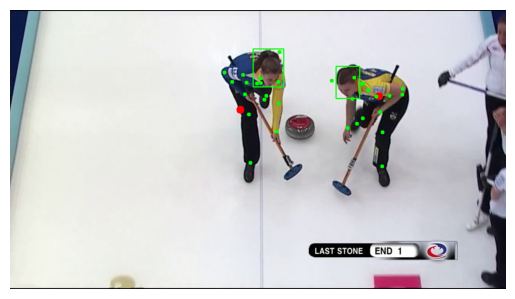

In [9]:
import matplotlib.pyplot as plt
import pprint
import math

list_annotations = release['annolist'][0][0][0]
exploration = list_annotations[4]

# print(exploration)
pp = pprint.PrettyPrinter(indent=4)

image_name = exploration['image'][0, 0]['name'][0]
print(f"Image Name is: {image_name}")

annotations = exploration['annorect'][0]
joint_id = {    0: "r ankle", 
                1: "r knee", 
                2: "r hip", 
                3: "l hip", 
                4: "l knee",
                5: "l ankle", 
                6: "pelvis", 
                7: "thorax", 
                8: "upper neck", 
                9: "head top", 
                10: "r wrist", 
                11: "r elbow", 
                12: "r shoulder", 
                13: "l shoulder", 
                14: "l elbow", 
                15: "l wrist"}
all_joints = []
head_tables = []
object = []
for i in range(len(annotations)):
    annotation = annotations[i]

    # print(annotation)
    
    print("Coordinates of the head rectangle is:")
    x1 = annotation['x1'][0, 0]
    x2 = annotation['x2'][0, 0]
    y1 = annotation['y1'][0, 0]
    y2 = annotation['y2'][0, 0]
    print(f"x1 is: {x1}")
    print(f"x2 is: {x2}")
    print(f"y1 is: {y1}")
    print(f"y2 is: {y2}")

    center_x = x1 + (x2 - x1) / 2
    center_y = y1 + (y2 - y1) / 2
    print(f"Center coordinates: {center_x}, {center_y}")
    
    head = (x1, y1, x2, y2)
    head_tables.append(head)
    
    print("====================================")
    
    print(f"Scale is: {annotation['scale'][0, 0]}")
    print(f"Object pos: ({annotation['objpos'][0, 0][0][0, 0]}, {annotation['objpos'][0, 0][1][0, 0]})")
    object.append((annotation['objpos'][0, 0][0][0, 0], annotation['objpos'][0, 0][1][0, 0]))
    
    
    joint_coordinates = []
    print("====================================")
    list_joints = annotation['annopoints']['point'][0, 0][0]
    print(f'Annotation point is:')
    
    for idx in range(len(list_joints)):
        joint = list_joints[idx]
        id = joint['id'][0, 0]
        
        joint_x = int(joint['x'][0, 0])
        joint_y = int(joint['y'][0, 0])
        # is_visibility = joint['is_visible'][0, 0]
        # print(joint)
        
        joint_coordinates.append([joint_x, joint_y, id])
    
    joint_coordinates = np.array(sorted(joint_coordinates, key=lambda x: x[2]))
    # print(joint_coordinates)
    # Add (0, 0) for any gaps in IDs
    filled_joint_coordinates = []

    indx = 0
    for i in range(len(joint_coordinates)):
        while indx < joint_coordinates[i, 2]:
            filled_joint_coordinates.append([0, 0, indx])
            indx += 1
        else:
            filled_joint_coordinates.append(joint_coordinates[i])
            indx += 1
            
    filled_joint_coordinates = np.array(filled_joint_coordinates)
    joint_coordinates = filled_joint_coordinates[:, :2]
    
    all_joints.append(joint_coordinates)


    print(joint_coordinates)
    print("================================================================i")
    
# Plot images
dataset_dir = './images'
image = os.path.join(dataset_dir, image_name)

# print(image)
# Read the image using OpenCV
img = cv2.imread(image)  # Replace 'image_path.jpg' with the path to your image
print(f"Shape of the Image is: {img.shape}")

# print(img)
# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



for i, joint_coordinates in enumerate(all_joints):
    head = head_tables[i]
    x1, y1, x2, y2 = head

    print(object[i])
    obj_x, obj_y = object[i]
    
    color = (0, 255, 0) 

    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, thickness = 2)
    cv2.circle(img_rgb, (obj_x, obj_y), 10, (255, 0, 0), -1) 
    for joint, (x, y) in enumerate(joint_coordinates):
        # Convert coordinates to integers
        x, y = int(x), int(y)
        # Draw a small circle around the joint
        cv2.circle(img_rgb, (x, y), 5, (0, 255, 0), -1)  # Green color, filled circle

# Display the image using matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()



In [172]:
import scipy.io
import scipy.misc
import numpy as np
import os
from tqdm.notebook import tqdm

# Load in annotations
datadir = './'
annotpath = 'mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'
annot = scipy.io.loadmat(annotpath)
annot = annot['RELEASE']
nimages = annot['img_train'][0][0][0].shape[0]

# Part info
parts = ['rank', 'rkne', 'rhip',
         'lhip', 'lkne', 'lank',
         'pelv', 'thrx', 'neck', 'head',
         'rwri', 'relb', 'rsho',
         'lsho', 'lelb', 'lwri']
nparts = len(parts)

def imgpath(idx):
    # Path to image
    filename = str(annot['annolist'][0][0][0]['image'][idx][0]['name'][0][0])
    # return datadir + '/images/' + filename
    return os.path.join(datadir, 'images', filename)

def loadimg(idx):
    # Load in image
    return scipy.misc.imread(imgpath(idx))

def numpeople(idx):
    # Get number of people present in image
    example = annot['annolist'][0][0][0]['annorect'][idx]
    if len(example) > 0:
        return len(example[0])
    else:
        return 0

def istrain(idx):
    # Return true if image is in training set
    return (annot['img_train'][0][0][0][idx] and
            annot['annolist'][0][0][0]['annorect'][idx].size > 0 and
            'annopoints' in annot['annolist'][0][0][0]['annorect'][idx].dtype.fields)

def location(idx, person):
    # Return center of person, and scale factor
    example = annot['annolist'][0][0][0]['annorect'][idx]
    if ((not example.dtype.fields is None) and
        'scale' in example.dtype.fields and
        example['scale'][0][person].size > 0 and
        example['objpos'][0][person].size > 0):
        scale = example['scale'][0][person][0][0]
        x = example['objpos'][0][person][0][0]['x'][0][0]
        y = example['objpos'][0][person][0][0]['y'][0][0]
        return np.array([x, y]), scale
    else:
        return [-1, -1], -1

def partinfo(idx, person, part):
    # Part location and visibility
    # This function can take either the part name or the index of the part
    if type(part) == type(''):
        part = parts.index(part)

    example = annot['annolist'][0][0][0]['annorect'][idx]
    # print(example['annopoints'][0])
    # print(example)
 
    try:
        if example['annopoints'][0][person].size > 0:
            parts_info = example['annopoints'][0][person][0][0][0][0]
            for i in range(len(parts_info)):
                if parts_info[i]['id'][0][0] == part:
                    if 'is_visible' in parts_info.dtype.fields:
                        v = parts_info[i]['is_visible']
                        v = v[0][0] if len(v) > 0 else 1
                        if type(v) is str:
                            v = int(v)
                    else:
                        v = 1
                    return np.array([parts_info[i]['x'][0][0], parts_info[i]['y'][0][0]], int), v
            return np.zeros(2, int), 0
        return -np.ones(2, int), -1
    except ValueError: 
        return np.zeros(2, int), 0

def normalization(idx, person):
    # Get head height for distance normalization
    if istrain(idx):
        example = annot['annolist'][0][0][0]['annorect'][idx]
        x1, y1 = int(example['x1'][0][person][0][0]), int(example['y1'][0][person][0][0])
        x2, y2 = int(example['x2'][0][person][0][0]), int(example['y2'][0][person][0][0])
        diff = np.array([y2 - y1, x2 - x1], np.float64)
        return np.linalg.norm(diff) * .6
    return -1

def torsoangle(idx, person):
    # Get angle from pelvis to thorax, 0 means the torso is up vertically
    pt1 = partinfo(idx, person, 'pelv')[0]
    pt2 = partinfo(idx, person, 'thrx')[0]
    if not (pt1[0] == 0 or pt2[0] == 0):
        return 90 + np.arctan2(pt2[1] - pt1[1], pt2[0] - pt1[0]) * 180. / np.pi
    else:
        return 0

# Create A New Dataset

Save to training.csv


In [88]:
import csv

csv_file = 'training.csv'

fieldnames = ['index', 'image_path', 'person', 'center', 
              'scale', 'normalize', 'part', 'visible', 'torsoangle']

with open(csv_file, mode='w', newline='') as csv_file:
    # Create a CSV writer object
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    # Write the header row
    writer.writeheader()
    
    # Loop over the indices
    for indx in tqdm(range(nimages), desc="Writing CSV"):
        image_path = imgpath(indx)
        num_people = numpeople(indx)
        is_train = istrain(indx)

        # print(is_train)
        if is_train:
            # Loop over the people in the image
            for people in range(num_people):
                is_visible = []
                joints_coordinates = []

                center, scale = location(indx, people)
                normalization_data = normalization(indx, people)

                for i in range(nparts):
                    joints_coordinates.append(partinfo(indx, people, i)[0])
                    is_visible.append(partinfo(indx, people, i)[1])

                torso_angle = torsoangle(indx, people)
                is_visible = np.array(is_visible)
                joints_coordinates = np.array(joints_coordinates)
                # Write data to the CSV file
                writer.writerow({
                    'index': indx,
                    'image_path': image_path,
                    'person': people,
                    'center': center,
                    'scale': scale,
                    'normalize': normalization_data,
                    'part': joints_coordinates,
                    'visible': is_visible,
                    'torsoangle': torso_angle
                })

Writing CSV:   0%|          | 0/24987 [00:00<?, ?it/s]

0
0
0
0
True
True
True
True
True
True
True
0
0
True
True
True
True
True
True
True
True
True
True
True
True
0
0
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
0
0
0
True
True
True
True
True
True
True
True
True
True
True
True
True
0
0
0
True
True
True
0
0
0
0
True
True
True
True
0
0
0
0
0
True
True
True
True
0
True
True
True
True
True
True
True
True
True
True
True
True
True
0
True
True
True
True
True
True
True
True
True
True
True
True
True
0
True
True
True
True
True
True
True
True
True
True
True
True
True
True
0
0
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
True
True
0
0
0
0
0
0
True
True
True
0
0
0
False
True
True
True
True
True
True
True
True
True
0
0
0
0
0
0
True
True
True
True
True
True
0
0
0
0
0
0
0
0
0
0
0
0
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
0
False
True
True
True

In [127]:
import pandas as pd

pd_file = pd.read_csv('training.csv')

# Define the 2-dimensional numpy array with [-1, -1]
target_array = np.array([[-1, -1]] * 16)

pd_file['part'] = pd_file['part'].apply(lambda x: np.fromstring(x.replace('[', '').replace(']', '').replace('\n', ''), sep=' ').reshape(-1, 2))

pd_file = pd_file[pd_file['part'].apply(lambda x: np.array_equal(x, target_array))]

# Reset the index
pd_file.reset_index(drop=True, inplace=True)

pd_file

,index,image_path,person,center,scale,normalize,part,visible,torsoangle
0,2248,./images/059897851.jpg,1,"[-1, -1]",-1.0,201.503548,"[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...",[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1],90.0
1,4916,./images/032783820.jpg,1,"[-1, -1]",-1.0,126.178445,"[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...",[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1],90.0
2,5602,./images/012525123.jpg,1,"[-1, -1]",-1.0,48.127331,"[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...",[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1],90.0
3,9953,./images/025130769.jpg,0,"[-1, -1]",-1.0,62.078982,"[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...",[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1],90.0
4,11272,./images/056338374.jpg,1,"[-1, -1]",-1.0,60.251473,"[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...",[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1],90.0
...,...,...,...,...,...,...,...,...,...
129,23850,./images/099879285.jpg,0,"[-1, -1]",-1.0,261.501587,"[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...",[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1],90.0
130,23851,./images/015883915.jpg,0,"[-1, -1]",-1.0,232.227905,"[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...",[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1],90.0
131,23957,./images/062020483.jpg,2,"[-1, -1]",-1.0,37.107951,"[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...",[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1],90.0
132,24732,./images/011387000.jpg,0,"[-1, -1]",-1.0,316.079294,"[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1...",[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1],90.0


In [156]:
partinfo(2248, 1, 0)

1


(array([-1, -1]), -1)

In [114]:
pd_file_center = pd_file[pd_file['center'].apply(lambda x: np.array_equal(x, [-1, 1]))]
pd_file_center

,index,image_path,person,center,scale,normalize,part,visible,torsoangle


In [115]:
pd_file_scale = pd_file[pd_file['center'].apply(lambda x: np.array_equal(x, [-1, 1]))]
pd_file_center

,index,image_path,person,center,scale,normalize,part,visible,torsoangle


Split to training and testing 

In [109]:
pd_file = pd_file.sample(frac=1, random_state=42).reset_index(drop=True)

# Define the split ratio (e.g., 80% training, 20% validation)
train_ratio = 0.9
valid_ratio = 1 - train_ratio

# Calculate the number of rows for each set
num_rows = len(pd_file)
train_rows = int(train_ratio * num_rows)
valid_rows = num_rows - train_rows

# Split the DataFrame into training and validation sets
train_set = pd_file.iloc[:train_rows]
valid_set = pd_file.iloc[train_rows:]

# Save the split sets to separate CSV files
train_file = 'training_set.csv'
valid_file = 'validation_set.csv'

train_set.to_csv(train_file, index=False)
valid_set.to_csv(valid_file, index=False)

# Display the first few rows of each set
print("Training Set:")
print(train_set.head(20))
print("\nValidation Set:")
print(valid_set.head(20))


Training Set:
    index              image_path  person       center     scale   normalize  \
0    8575  ./images/006986192.jpg       0    [993 462]  1.709231   42.730785   
1   16196  ./images/063173618.jpg       2    [434 285]  2.424475   60.611880   
2    1113  ./images/053697442.jpg       0    [334 200]  2.212821   55.320521   
3    1432  ./images/048884658.jpg       0    [147 250]  3.706971   92.674268   
4    8836  ./images/050306832.jpg       2  [1373  436]  4.322266  108.056652   
5   15059  ./images/015161064.jpg       0    [325 151]  1.930770   48.269245   
6   20733  ./images/053370150.jpg       1    [696 319]  3.789417   94.735421   
7   14685  ./images/076127143.jpg       3    [998 320]  2.102844   52.571095   
8    2622  ./images/043381742.jpg       0    [416 252]  3.298494   82.462355   
9   24207  ./images/055269569.jpg       1  [1202  509]  3.024381   75.609523   
10    273  ./images/091324055.jpg       7    [923 395]  1.002557   25.063918   
11   7868  ./images/035784

In [77]:
pd_file.shape

(29017, 9)

In [116]:
training = pd.read_csv('training_set.csv')

# Define the 2-dimensional numpy array with [-1, -1]
training.head()

,index,image_path,person,center,scale,normalize,part,visible,torsoangle
0,8575,./images/006986192.jpg,0,[993 462],1.709231,42.730785,[[ 991. 658.]\n [1026. 575.]\n [ 961. 497.]...,[1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0],31.827447
1,16196,./images/063173618.jpg,2,[434 285],2.424475,60.611880,[[438. 538.]\n [439. 445.]\n [433. 338.]\n [48...,[1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1],1.636577
2,1113,./images/053697442.jpg,0,[334 200],2.212821,55.320521,[[ 0. 0.]\n [332. 377.]\n [317. 273.]\n [37...,[0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0],-3.179830
3,1432,./images/048884658.jpg,0,[147 250],3.706971,92.674268,[[ 0. 0.]\n [ 0. 0.]\n [ 48. 417.]\n [12...,[0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1],17.712012
4,8836,./images/050306832.jpg,2,[1373 436],4.322266,108.056652,[[1189. 956.]\n [1276. 735.]\n [1206. 513.]...,[0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1],8.214818


# Creating the Testing Set

In [183]:
import csv

csv_file = 'test.csv'

fieldnames = ['index', 'image_path', 'person', 'center', 
              'scale', 'normalize', 'part', 'visible', 'torsoangle']
error_index = []

with open(csv_file, mode='w', newline='') as csv_file:
    # Create a CSV writer object
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    
    # Write the header row
    writer.writeheader()
   
    # Loop over the indices
    for indx in tqdm(range(nimages), desc="Writing CSV"):
        image_path = imgpath(indx)
        num_people = numpeople(indx)
        is_train = istrain(indx)

        # print(is_train)
        if is_train == False:
            # Loop over the people in the image
            for people in range(num_people):
                is_visible = []
                joints_coordinates = []

                center, scale = location(indx, people)
                normalization_data = normalization(indx, people)

                for i in range(nparts):
                    try:
                        coordinates = partinfo(indx, people, i)[0]
                        joints_coordinates.append(coordinates[0])
                        is_visible.append(coordinates[1])
                    except IndexError:
                        error_index.append(indx)

                try:
                    torso_angle = torsoangle(indx, people)
                except IndexError: 
                    torso_angle = 0
                    
                is_visible = np.array(is_visible)
                joints_coordinates = np.array(joints_coordinates)
                
                # Write data to the CSV file
                writer.writerow({
                    'index': indx,
                    'image_path': image_path,
                    'person': people,
                    'center': center,
                    'scale': scale,
                    'normalize': normalization_data,
                    'part': joints_coordinates,
                    'visible': is_visible,
                    'torsoangle': torso_angle
                })

Writing CSV:   0%|          | 0/24987 [00:00<?, ?it/s]

In [194]:
import pandas as pd

file = pd.read_csv('test.csv')
file.shape

(11922, 9)

In [195]:
error_index = set(error_index)
filtered_file = file[~file['index'].isin(error_index)]
print(filtered_file)

       index              image_path  person       center     scale  \
0          0  ./images/037454012.jpg       0    [601 380]  3.880734   
1          1  ./images/095071431.jpg       0    [881 394]  8.078166   
2          1  ./images/095071431.jpg       1    [338 210]  8.904129   
3          2  ./images/073199394.jpg       0    [619 350]  4.326662   
4          3  ./images/059865848.jpg       0    [684 309]  4.928480   
...      ...                     ...     ...          ...       ...   
11917  24973  ./images/056300476.jpg       0  [1060  399]  2.019568   
11918  24985  ./images/092025825.jpg       0  [1224  553]  9.880337   
11919  24985  ./images/092025825.jpg       1    [473 587]  8.619509   
11920  24986  ./images/053686627.jpg       0  [1277  681]  8.844122   
11921  24986  ./images/053686627.jpg       1    [526 503]  8.733362   

       normalize                               part  \
0             -1  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]   
1             -1  [0 0 0 0 0 0 0 0 0 

In [200]:
filtered_file.to_csv('test.csv', index = False)

In [201]:
abc = pd.read_csv('test.csv')

In [202]:
abc.head()

,index,image_path,person,center,scale,normalize,part,visible,torsoangle
0,0,./images/037454012.jpg,0,[601 380],3.880734,-1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],0
1,1,./images/095071431.jpg,0,[881 394],8.078166,-1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],0
2,1,./images/095071431.jpg,1,[338 210],8.904129,-1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],0
3,2,./images/073199394.jpg,0,[619 350],4.326662,-1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],0
4,3,./images/059865848.jpg,0,[684 309],4.928480,-1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],0
